<a target="_blank" href="https://colab.research.google.com/github/impresso/impresso-datalab-notebooks/blob/main/workshop_resources/ws4-embeddings/EventDetectionGranularity.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Granularity, Events and Embeddings

This notebooks provides basic functionality for embedding texts at different levels, from the whole article to chunks and headlines. The main purpose is to showcase the retrieval and embedding functionalities of the Impresso API, as well as provide some code for visualising embeddings using dimensionality reduction.

## Install required packages

In [1]:
!pip -qqq install pandas chonkie faiss-cpu tqdm seaborn plotly umap-learn

In [2]:
!pip -qqq install git+https://github.com/impresso/impresso-py.git@embeddings-search

In [3]:
# # restart the kernel just in case...
# import os
# os.kill(os.getpid(), 9)

## Load and process data

In [2]:
!pip install gdown

In [1]:
!gdown 1H8_1-PbGPlcrm3wvwd1xGaUrhNnYETha

Downloading...
From: https://drive.google.com/uc?id=1H8_1-PbGPlcrm3wvwd1xGaUrhNnYETha
To: /Users/eboros/projects/4_impresso/impresso-datalab-notebooks/workshop_resources/ws4-embeddings/Olympics-general.zip
100%|██████████████████████████████████████| 21.2M/21.2M [00:00<00:00, 27.1MB/s]


In [4]:
# unzip the data for the general query
!unzip -o Olympics-general.zip -d data

Archive:  Olympics-general.zip
  inflating: data/2025-10-20T13-28-55-45260b95.csv  


In [1]:
import os
import pandas as pd
from chonkie import SemanticChunker
from tqdm import tqdm
import faiss
import numpy as np
from impresso import connect

## Connect to the Impresso client

In [147]:
impresso_session = connect('https://dev.impresso-project.ch/public-api/v1')


Click on the following link to access the login page: https://dev.impresso-project.ch/datalab/token
 - 🔤 Enter your email/password on this page.
 - 🔑 Once logged in, a secret token will be generated for you.
 - 📋 Copy this token and paste it into the input field below. Then press "Enter". 👇🏼.



🔑 Enter your token:  ········


🎉 You are now connected to the Impresso API!  🎉
🔗 Using API: https://dev.impresso-project.ch/public-api/v1


## Load helper functions

In [3]:
# embed text helper functions
import time
import base64
import struct

def embed_text(text: str, target: str):
  """
  Convert text to embedding, return None in case of an error
  """
  # time.sleep(1)
  try:
    return impresso_session.tools.embed_text(text, target)
  except Exception as e:
    print(text)
    print(e)
    return None


def convert_embedding(embedding: np.float32):
  """
  Convert base64 string to a float array
  """
  if not embedding:
    return None

  _, arr = embedding.split(':')
  arr = base64.b64decode(arr)
  outof_corpus_emb = [struct.unpack('f', arr[i:i+4])[0] for i in range(0, len(arr), 4)]
  return outof_corpus_emb

## Load data

The data file is csv document containing articles mentioning "Olympic Games"

In [5]:
# --- CONFIG ---
CSV_PATH = "data/2025-10-20T13-28-55-45260b95.csv"         # Path to your CSV file


In [6]:
df = pd.read_csv(CSV_PATH, sep=';',skiprows=4)
df.head(3)

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,provinceCode,publicationDate,relevance,title,topics,totalPages,transcript,transcriptLength,type,year
0,BNN-1886-02-09-a-i0002,NaN,NaN,CH,SNL,Allerlei Notizen — In der italienischen Gemein...,False,NaN,True,BNN-1886-02-09-a,...,GR,1886-02-09T00:00:00Z,4.885939,Allerlei Notizen,tm-de-all-v2.0_tp47_de|0.298 tm-de-all-v2.0_tp...,1,Allerlei Notizen — In der italienischen Gemein...,219,ar,1886
1,BNN-1889-05-21-a-i0027,NaN,NaN,CH,SNL,n Das Turnen itt der Volksschule Als das Turne...,True,NaN,True,BNN-1889-05-21-a,...,GR,1889-05-21T00:00:00Z,2.840050,n Das Turnen itt der Volksschule,tm-de-all-v2.0_tp30_de|0.395 tm-de-all-v2.0_tp...,1,n Das Turnen itt der Volksschule Als das Turne...,1204,ar,1889
2,BNN-1891-09-06-a-i0034,NaN,NaN,CH,SNL,"Iugendspiele Immer lebhafter, so schreiben die...",True,NaN,True,BNN-1891-09-06-a,...,GR,1891-09-06T00:00:00Z,2.208386,Iugendspiele,tm-de-all-v2.0_tp92_de|0.175 tm-de-all-v2.0_tp...,1,"Iugendspiele Immer lebhafter, so schreiben die...",1655,ar,1891


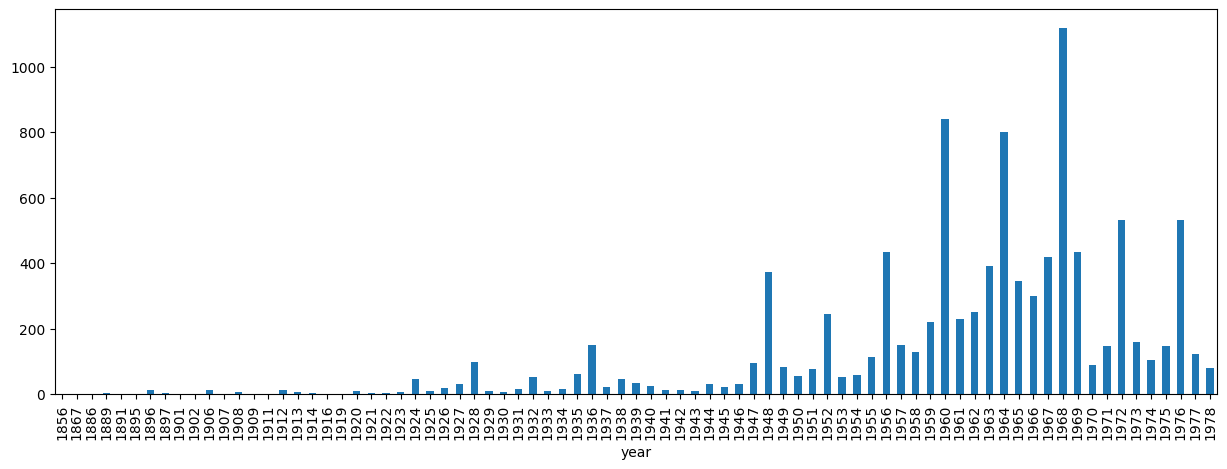

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # increase width (15) and height (5)
_ = df['year'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [17]:
df.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year'],
      dtype='object')

In [8]:
# to reduce the data a bit let's focus on the 30s and 40?
df_period = df[df.year.between(1930, 1950) & ~(df['title'].isnull())]
df_period.shape

(1137, 29)

In [21]:
df_period.excerpt.unique()

array(['MOMMOMLM von Woche zu Woche. Deutschland und Italien haben die Einladung zur Teil » nahm « an der neuen Locarnolonferenz angenommen. Deutschland hat k',
       'Reorganisation im Sportbetriebt Mit der Veendigung der Olympischen Spiele in Verlin ist es lim die Frage der Reorganisation der Sportbewegung wieder l',
       'allen gnten Geistern verlassen, soweit gebracht, daß die Abwcrtnng noch als einziges Allheilmittel verblieb. Und nun? Ende September sprach der Ehef d',
       ...,
       "L'assemblée générale de la Société fédérale de gymnastique Samedi s est réunie à Genève, en présence de quelque 300 délégués et invités, l'assemblée g",
       "Les grands anniversaires d'octobre (SUITE l > i ; I. A PREMIER *; PAOE) Mais le voyageur canadien ne s'en tint pas là ; avant de mourir, le 18 oct obr",
       "Rencontres internationales S'il est deux sports qui attirent les foules ce sont bien le football et le hockey sur glace. Aussi demain, les amateurs de"],
      dtype=object)

In [63]:
df_period

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,totalPages,transcript,transcriptLength,type,year,title_embedding,article_embedding,cluster,x,y
4,DTT-1936-08-05-a-i0029,NaN,NaN,CH,Migros,MOMMOMLM von Woche zu Woche. Deutschland und I...,False,NaN,True,DTT-1936-08-05-a,...,1,MOMMOMLM von Woche zu Woche. Deutschland und I...,302,ar,1936,"[-0.028241433200000002, 0.0498822145, -0.03026...","[-0.0446898863, 0.0711098164, -0.076359801, 0....",36,20.456684,2.278999
5,DTT-1936-11-04-a-i0010,NaN,NaN,CH,Migros,Reorganisation im Sportbetriebt Mit der Veendi...,False,NaN,True,DTT-1936-11-04-a,...,1,Reorganisation im Sportbetriebt Mit der Veendi...,987,ar,1936,"[-0.0648515597, 0.0540305525, -0.0215939153000...","[-0.036840003, 0.0622400083, -0.04718000810000...",2,0.558633,-11.793377
6,DTT-1936-11-18-a-i0007,NaN,NaN,CH,Migros,"allen gnten Geistern verlassen, soweit gebrach...",False,NaN,True,DTT-1936-11-18-a,...,1,"allen gnten Geistern verlassen, soweit gebrach...",1173,ar,1936,"[-0.046515867100000004, 0.08611497280000001, -...","[-0.0534400754, 0.0507000722, 0.01162001580000...",27,18.691334,-17.999729
7,DTT-1938-10-07-a-i0041,NaN,NaN,CH,Migros,v « r Iv 1 ill »_ rsllofe! ls » « l « l « r zu...,False,NaN,True,DTT-1938-10-07-a,...,1,v « r Iv 1 ill »_ rsllofe! ls » « l « l « r zu...,407,ar,1938,"[-0.049497313800000005, 0.0891617611, -0.02819...","[-0.06975952540000001, 0.0835994333, -0.042819...",48,19.871487,8.062947
8,DTT-1939-05-19-a-i0028,NaN,NaN,CH,Migros,"inen Dokumentarfilm diesem Film die schöne, üb...",False,NaN,True,DTT-1939-05-19-a,...,1,"inen Dokumentarfilm diesem Film die schöne, üb...",925,ar,1939,"[-0.0354509056, 0.0520240963, -0.0155817205, 0...","[-0.0448499247, 0.015469973900000001, -0.04914...",17,37.620613,0.875946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,EXP-1950-07-31-a-i0069,NaN,NaN,CH,SNL,Les athlètes militaires démontrent Samedi et d...,False,NaN,True,EXP-1950-07-31-a,...,1,Les athlètes militaires démontrent Samedi et d...,1549,ar,1950,"[-0.062127765300000005, 0.0549592525, -0.07396...","[-0.0713501424, 0.064220123, -0.0799801648, -0...",38,-18.663597,-2.231919
5712,EXP-1950-09-06-a-i0209,NaN,NaN,CH,SNL,SAINT-AUBIN Fête sportive de l '« _Helvétia » ...,False,NaN,True,EXP-1950-09-06-a,...,1,SAINT-AUBIN Fête sportive de l '« _Helvétia » ...,333,ar,1950,"[-0.12399900700000001, 0.0835530609, 0.0009503...","[-0.0946995169, 0.0643896759, -0.0344998240000...",1,-13.007402,9.963512
5713,EXP-1950-10-16-a-i0058,NaN,NaN,CH,SNL,L'assemblée générale de la Société fédérale de...,False,NaN,True,EXP-1950-10-16-a,...,1,L'assemblée générale de la Société fédérale de...,458,ar,1950,"[-0.1095588952, 0.0034698821, -0.0334893726000...","[-0.09497991950000001, 0.0143499877, -0.024639...",20,-1.745623,-14.977065
5714,EXP-1950-10-17-a-i0094,NaN,NaN,CH,SNL,Les grands anniversaires d'octobre (SUITE l > ...,False,NaN,True,EXP-1950-10-17-a,...,1,Les grands anniversaires d'octobre (SUITE l > ...,664,ar,1950,"[-0.0068093333, 0.0783717558, -0.0870000869000...","[0.0242499691, 0.0940998718, -0.0165799782, -0...",48,-0.244658,23.992823


## Embed Headlines

In [22]:
tqdm.pandas()
df_period['excerpt_embedding'] = df_period['excerpt'].progress_apply(
    lambda x: convert_embedding(embed_text(x, 'text')))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1137/1137 [05:37<00:00,  3.37it/s]


In [23]:
# let's first get the embeddings of the transcript title and look

tqdm.pandas()
df_period['title_embedding'] = df_period['title'].progress_apply(
    lambda x: convert_embedding(embed_text(x, 'text')))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1137/1137 [05:32<00:00,  3.42it/s]


## Retrieve transcript embeddings

In [26]:
# get the article embeddings from the API

def get_embedding_by_uid(uid):
  time.sleep(1)
  try:
    return convert_embedding(impresso_session.content_items.get_embeddings(uid)[0])
  except Exception as e:
    # print(e)
    # print(uid)
    pass
    return None

df_period['article_embedding']  = df_period.uid.progress_apply(get_embedding_by_uid)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1137/1137 [21:03<00:00,  1.11s/it]


In [75]:
sentence = "winterspiele"



## Save data

In [26]:
df_period.to_json('olympic-general-embedded.json')

## Plot Embeddings with UMAP

Plot either transcript (i.e. article) or headline (i.e. title) embeddings with dimensionality reduction.

In [37]:
!gdown 18SyEXcXjRTyu3UOzDOFZdDb16jA2ejmM

Downloading...
From: https://drive.google.com/uc?id=18SyEXcXjRTyu3UOzDOFZdDb16jA2ejmM
To: /Users/eboros/projects/4_impresso/impresso-datalab-notebooks/workshop_resources/ws4-embeddings/olympic-general-embedded.json
100%|██████████████████████████████████████| 29.1M/29.1M [00:01<00:00, 27.8MB/s]


In [77]:
df_period = pd.read_json('olympic-general-embedded.json')

len(df_period)

1137

In [78]:
df_period = df_period.dropna(subset=['article_embedding'])

In [ ]:
# --- DIMENSIONALITY REDUCTION ---
from umap import UMAP
print("Reducing to 2D with UMAP...")
reducer = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

EMBEDDING = 'article_embedding' # 'title_embedding' | 'article_embedding'

df_period = pd.read_json('olympic-general-embedded.json')

df_period = df_period[~df_period[EMBEDDING].isnull()]

embeddings = list(df_period[EMBEDDING])
embeddings_2d = reducer.fit_transform(embeddings)

df_period["x"] = embeddings_2d[:, 0]
df_period["y"] = embeddings_2d[:, 1]

Reducing to 2D with UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [79]:
EMBEDDING = 'article_embedding' # 'title_embedding' | 'article_embedding'


In [80]:
len(df_period)


1002

In [81]:
for x in df_period["article_embedding"]:
    if x is None:
        print(x)

In [82]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.vstack(df_period["article_embedding"].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df_period["cluster"] = kmeans.fit_predict(X)


In [83]:
from collections import Counter

for cluster_id in sorted(df_period["cluster"].unique()):
    subset = df_period[df_period["cluster"] == cluster_id]
    # print(subset)
    # top_occupations = Counter(subset["occupation"]).most_common(3)
    
    # print(f"\n🟩 Cluster {cluster_id}  —  size: {len(subset)}")
    # print("Top occupations:", [occ for occ, _ in top_occupations])
    # print("Sample entities:")
    
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        print(f"   • {row['transcript'][:10]}... — {row['transcriptLength']}")
    #     print(f"     {row['wiki_url_s']}")

   • J >* H Ift... — 1689
   • Sport-Vors... — 1188
   • Internatio... — 1847
   • Mannschaft... — 1079
   • _TlauueUes... — 574
   • alles gut;... — 312
   • Le congrès... — 521
   • La séance ... — 262
   • L'assemblé... — 340
   • « Die Schw... — 326
   • HERMi & m ... — 151
   • Les Jeux o... — 464
   • nicht, son... — 318
   • Aux Jeux o... — 2417
   • Olympische... — 2916
   • Im Kunstha... — 1507
   • Deutschlan... — 279
   • John Lewis... — 2358
   • La pénurie... — 242
   • Neuchâtel-... — 387
   • ^ l ^ o ra... — 314
   • ^ L ^ ora ... — 577
   • Emissions ... — 294
   • Emissions ... — 506
   • Emissions ... — 518


In [84]:
tsne = TSNE(n_components=2, perplexity=35, random_state=42)
X_2d = tsne.fit_transform(X)
df_period["x"], df_period["y"] = X_2d[:, 0], X_2d[:, 1]

Text(0, 0.5, 't-SNE 2')

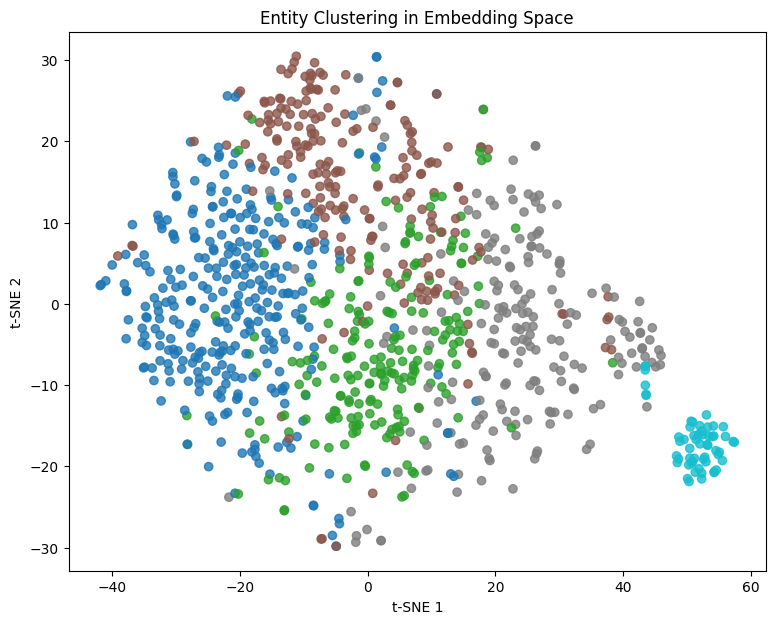

In [85]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(df_period["x"], df_period["y"], c=df_period["cluster"], cmap="tab10", alpha=0.8)
plt.title("Entity Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")


In [87]:
df_period.columns
df_period.head(1)

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,totalPages,transcript,transcriptLength,type,year,title_embedding,article_embedding,cluster,x,y
4,DTT-1936-08-05-a-i0029,NaN,NaN,CH,Migros,MOMMOMLM von Woche zu Woche. Deutschland und I...,False,NaN,True,DTT-1936-08-05-a,...,1,MOMMOMLM von Woche zu Woche. Deutschland und I...,302,ar,1936,"[-0.028241433200000002, 0.0498822145, -0.03026...","[-0.0446898863, 0.0711098164, -0.076359801, 0....",3,20.456684,2.278999


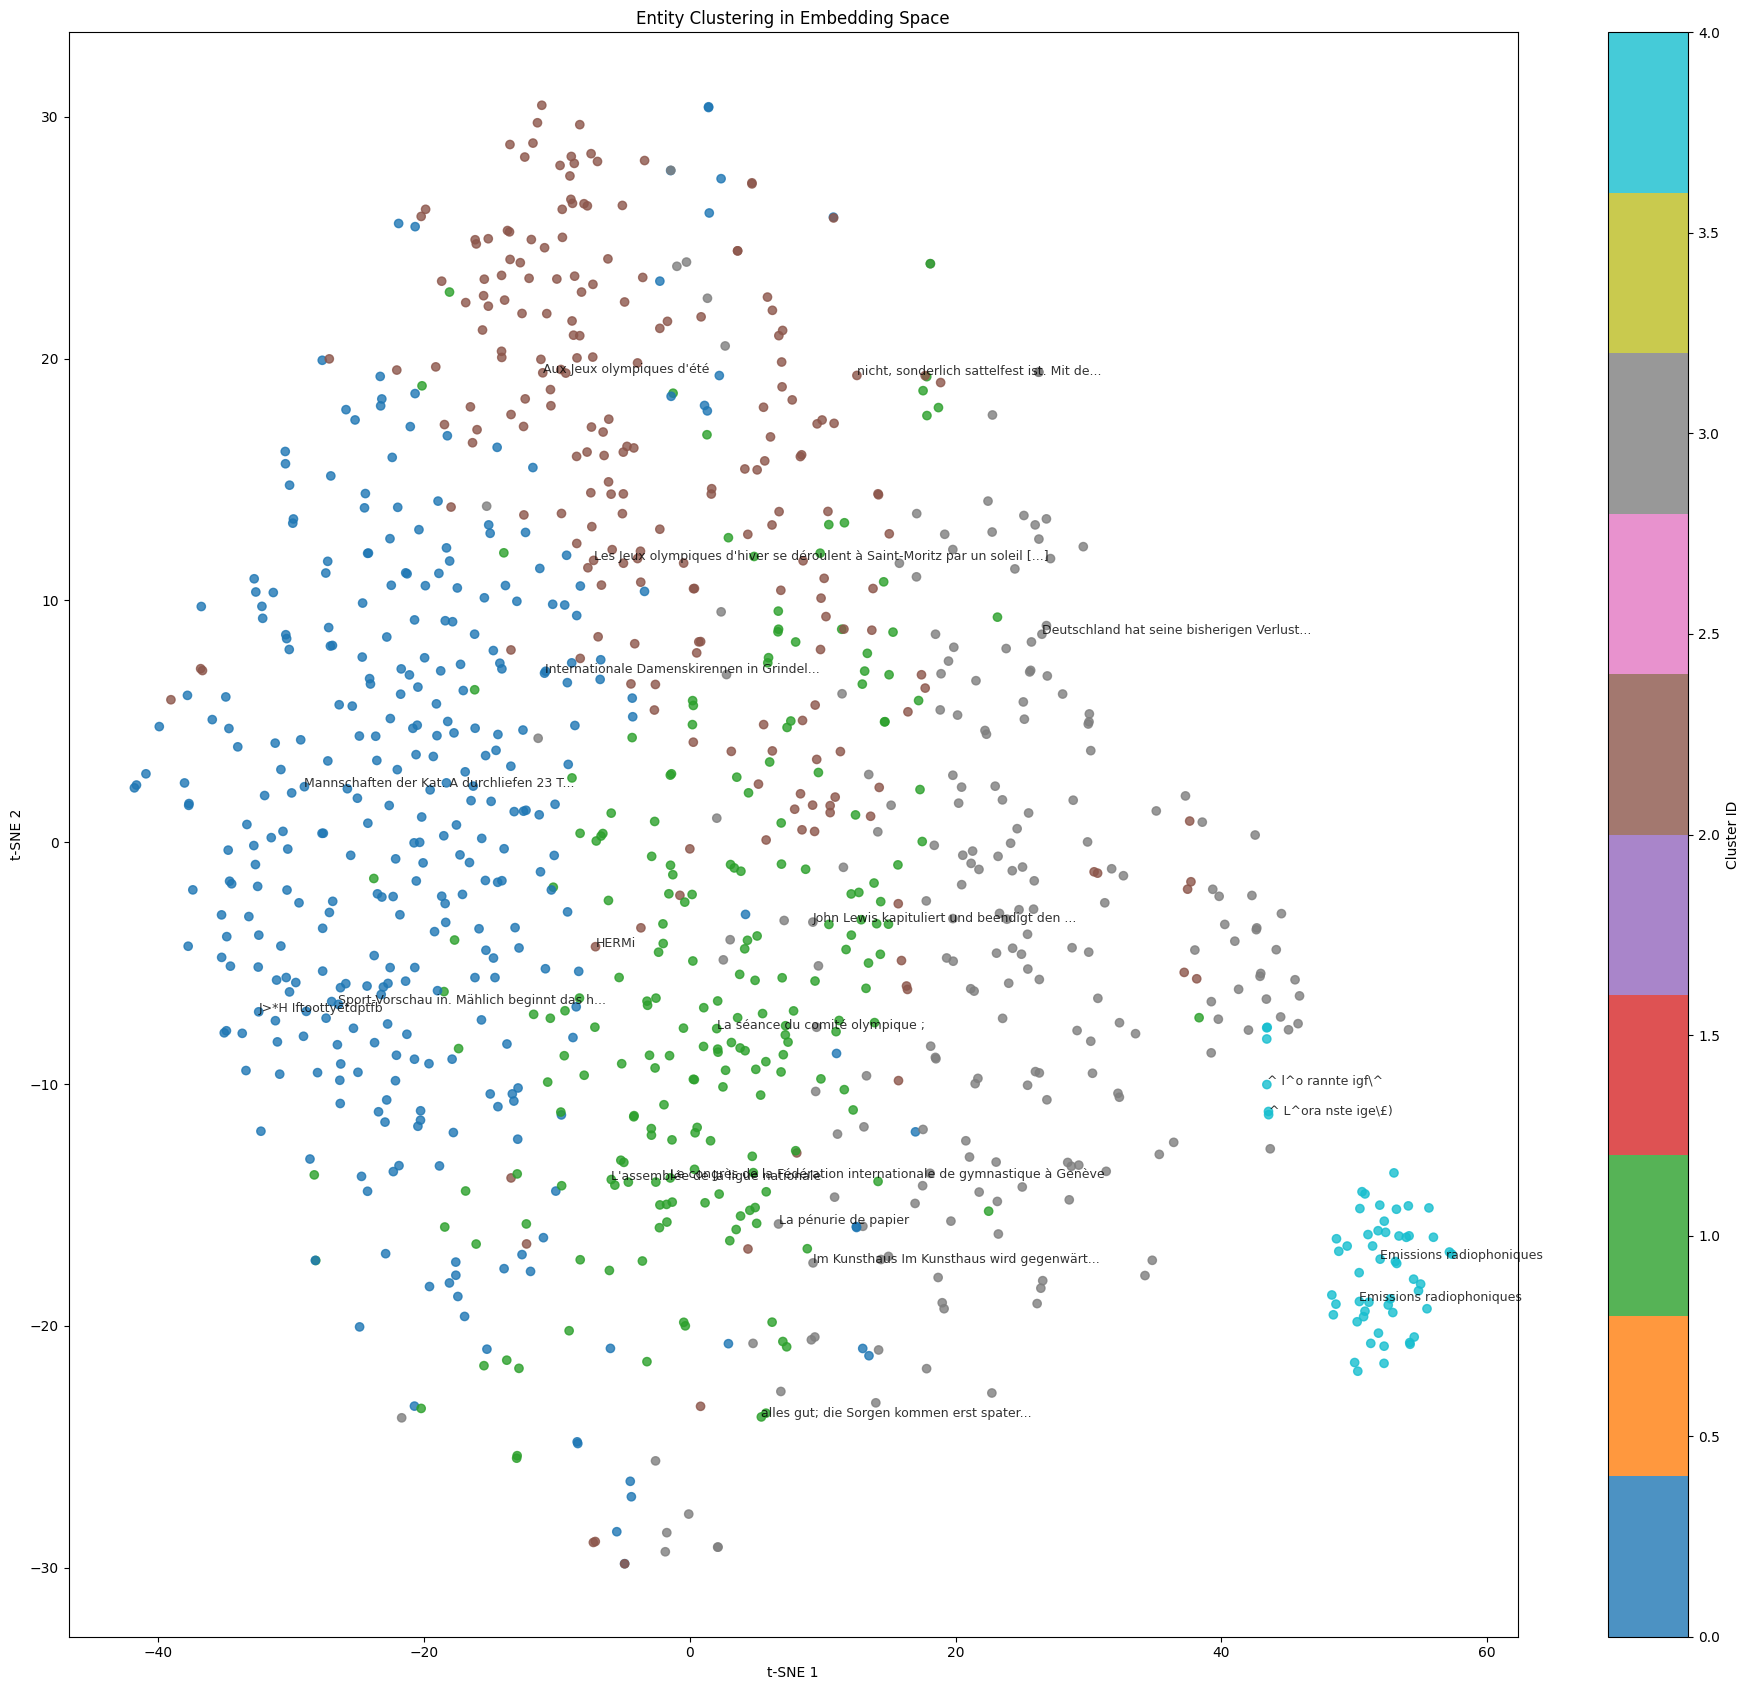

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(19, 17))
scatter = plt.scatter(df_period["x"], df_period["y"], c=df_period["cluster"], cmap="tab10", alpha=0.8)
plt.title("Entity Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

for cluster_id in df_period["cluster"].unique():
    sample = df_period[df_period["cluster"] == cluster_id].sample(4, random_state=42)
    for _, row in sample.iterrows():
        plt.text(row["x"], row["y"], row["title"], fontsize=9, alpha=0.8)

# Option 2 (alternative): label a few well-known or random ones
# for _, row in df.sample(15, random_state=0).iterrows():
#     plt.text(row["x"], row["y"], row["name"], fontsize=8, alpha=0.7)

plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

In [69]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [70]:
df_period.locations_mentioned

4                                 Italien|Berlin|Nürnberg
5                                                  Verlin
6       St. Gallen|Schweiz|Oesterreich|England|Vereini...
7       Bitler|Deutschland|Mitteleuropa|Tokio|Fernen O...
8                                         Schwyz|Helsinki
                              ...                        
5711    Neuchâtei|Neuchâtei|Berne|Berne|Berne|Berne|Be...
5712                  Londres|rues de Saint-Aubin|Yverdon
5713             Genève|Genève|Lausanne|Helsinki|Finlande
5714                                                 None
5715    Genève|Dolder|Brésil|Londres|Charmilles|Suisse...
Name: locations_mentioned, Length: 1002, dtype: object

In [11]:
df_period.persons_mentioned.unique()

array([None, 'Dr. H. Walder', 'Herr Minister Stucki|Gaulle', 'Mussolini',
       'Stelfichaps|Fe',
       'Robert Haab gestorben|Präsident des Obergerichtes des Kantons Zürich|Ältbundesrat Haab|Mitget|Fraucnvercine|Frl|FraucnstimmrechtsTcrband|Frau|Zentralpräsident Charles Thoeni|Vorsteher des Erzieliungsdeparteinentes von Baselstadt, Regierungsrat Dr. Hauser|Kunstturnerverbandes|Hierauf erstaltete Sekretär Edwin Wyler|Vizepräsident A. Schreiber ( Wengi|General Guisan|Liestal, 14|Prof. Dr|St. Galten, 15|Ernst Hürlimann|bisherigen Ständeräte Ludwig Walker|Dr. Leo Meyer',
       'General Guisan|Major Albert Mayer|anrichtete|Direktor des Zentralamtes für China, Generalleulnant Yanagawa|TSCbUnking|Regierung von Tschunking',
       'Rudolf Graf|Paul Valär|Willy Klopfenstein|2. Peter Kaufmann|Fritz Stäger|Ernst Steuri|Fritz Matti|Otto Boß|Christian Schmid|Fritz Studer|Ernst Küenzi|Otto von Allmen|Hans von Allmen|3. Fritz Tschannen|Rudolf Felber|Walter Ludi ( Gstaad|Christian Kaufmann|Hans Ru

In [12]:
df_period.newsagencies_mentioned.unique()

array([None,
       'ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.',
       'ag.|ag.|United Preß|United Preß|DNB|Havas|Havas|United Preß|United Preß|Reuter|Havas|Havas|ag.|ag.',
       'ag.|Reuter',
       'Havas|Havas|Havas|Havas|Havas|Havas|DNB|Havas|Havas|Havas|Havas|Havas|Havas|ag.|ag.|ag.|ag.',
       'ag.', 'Reuter', 'Exchange', 'AJK|AJK|AJK|AJK|AJK|AJK',
       'Exchange|Reuter', 'Reuter|Reuter|Reuter|Exchange|United-Preß',
       'Exchange|Exchange|Exchange|Exchange|Reuter|Reuter|Reuter|AFP|AFP|Reuter|Reuter|Reuter|United Preß',
       'Reuter|Reuter|AFP|Exchange|Exchange|United-Preß|Exchange|Exchange|Reuter|Reuter|Beuter',
       'Exchange|Exchange|Exchange|Reuter|Reuter',
       'United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|United Preß|AFP',
       'AFP|United Press', 'Reuter|AFP', 'United Press',
       'Reuter|United|United|Uni

In [13]:
# def clean_text(text, max_len=250):
#     """Truncate text and replace newlines for nicer tooltips"""
#     text = str(text).replace("\n", " ")
#     return text[:max_len] + ("..." if len(text) > max_len else "")

# df_period["hover_text"] = df_period.title.apply(clean_text)


In [89]:
# # normalized, size = individual, colour = servants
# import seaborn as sns
# import plotly.express as px

# fig = px.scatter(df_period,
#                  x="x",
#                  #size='all_inds',
#                  y="y",
#                  #color="all_inds",
#                  hover_data=['hover_text',"year"],
#                  width=1000, height=1000)
# fig.update_layout(showlegend=False)
# fig.show()

# Query

The example code below shows how create a local vector database with FAISS, which you can then query. You should be able to create a database at different levels (i.e. article, title or chunk).

The code for creating chunk level embeddings is shown below.

In [ ]:
!gdown 1Z5bGLddcCuwxAv4Ehu4Jt1QGNUh5CgYZ

In [90]:
# --- VECTOR STORE (FAISS) ---
# save index

EMBEDDING_LEVEL = 'chunk' # 'title' | 'article' | 'chunk'
# see below for chunking script

if EMBEDDING_LEVEL == 'chunk':
  df_period = pd.read_json('olympic-general-chunks-sample-embedded.json')
else:
  df_period = pd.read_json('olympic-general-embedded.json')
df_period = df_period[~df_period[f'{EMBEDDING_LEVEL}_embedding'].isnull()]

embeddings = list(df_period[EMBEDDING])

VECTOR_DB_PATH = f"vector_db_{EMBEDDING_LEVEL}.faiss"
embeddings = np.array(list(df_period[f'{EMBEDDING_LEVEL}_embedding']), dtype="float32")

dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)
faiss.write_index(index, VECTOR_DB_PATH)
print(f"Vector DB saved to {VECTOR_DB_PATH}")


Vector DB saved to vector_db_chunk.faiss


Now you can search for different subthemes within the data (i.e. score each document to the similarity of the query embedding)

In [91]:

query = "Weltkrieg"
q_emb = convert_embedding(embed_text(query,'text'))

D, I = index.search(np.array([q_emb], dtype="float32"), k=5)
print("Top 5 most similar chunks:")
df_period.iloc[I[0]]

Top 5 most similar chunks:


,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,topics,totalPages,transcript,transcriptLength,type,year,title_embedding,article_embedding,chunks,chunk_embedding
131,DTT-1948-07-06-a-i0051,NaN,NaN,CH,Migros,"einem Heerlager vieler Tausender wurde, die je...",False,NaN,True,DTT-1948-07-06-a,...,tm-de-all-v2.0_tp72_de|0.329 tm-de-all-v2.0_tp...,1,"einem Heerlager vieler Tausender wurde, die je...",403,ar,1948,"[-0.0721138045, 0.09350985290000001, -0.050409...","[-0.077970013, 0.07143001260000001, -0.0301400...","{'context': None, 'embedding': None, 'end_inde...","[-0.0822255835, 0.067227304, -0.0277234726, 0...."
684,EXP-1949-09-02-a-i0072,NaN,NaN,CH,SNL,Depuis 193 % Hitler menait l'Allemagne à la gu...,False,NaN,True,EXP-1949-09-02-a,...,tm-fr-all-v2.0_tp29_fr|0.208 tm-fr-all-v2.0_tp...,1,Depuis 193 % Hitler menait l'Allemagne à la gu...,516,ar,1949,"[-0.0728035048, 0.0546436459, -0.0220011752, 0...","[-0.0832703263, 0.042020164400000004, -0.07263...","{'context': None, 'embedding': None, 'end_inde...","[-0.0889383629, 0.049241703000000005, -0.04821..."
518,DTT-1948-01-31-a-i0173,NaN,NaN,CH,Migros,^^ tllfllgfllLl l ^ Die Winterspiele sind eröf...,False,NaN,True,DTT-1948-01-31-a,...,tm-de-all-v2.0_tp76_de|0.414 tm-de-all-v2.0_tp...,1,^^ tllfllgfllLl l ^ Die Winterspiele sind eröf...,2383,ar,1948,"[0.0054097627, 0.03400518, -0.0646223873, 0.01...","[-0.01531005, 0.0723602399, -0.0379601233, -0....","{'context': None, 'embedding': None, 'end_inde...","[-0.0728371963, 0.0552824959, -0.0469462909, 0..."
862,EXP-1936-08-08-a-i0058,NaN,NaN,CH,SNL,LA SUPÉRIORITÉ DES ALLEMANDS ET SON SECRET L'a...,False,NaN,True,EXP-1936-08-08-a,...,tm-fr-all-v2.0_tp59_fr|0.245 tm-fr-all-v2.0_tp...,1,LA SUPÉRIORITÉ DES ALLEMANDS ET SON SECRET L'a...,1058,ar,1936,"[-0.1145542115, 0.062110617800000004, -0.05135...","[-0.041139975200000005, 0.0859599486, -0.01864...","{'context': None, 'embedding': None, 'end_inde...","[-0.08712537590000001, 0.0861378089, -0.025508..."
528,DTT-1947-01-23-a-i0077,NaN,NaN,CH,Migros,OttJtiTfeshen / Fuß baller-Arithmetik eb.-Währ...,False,NaN,True,DTT-1947-01-23-a,...,tm-de-all-v2.0_tp09_de|0.316 tm-de-all-v2.0_tp...,1,OttJtiTfeshen / Fuß baller-Arithmetik eb.-Währ...,3172,ar,1947,"[-0.0401747935, 0.0452223867, -0.0099714985, 0...","[-0.07676000150000001, 0.11800999940000001, 0....","{'context': None, 'embedding': None, 'end_inde...","[-0.0515924878, 0.1245880201, -0.0347093567, 0..."


# Chunk

The code below shows how create chunk level embeddings. We apply this only to a small sample as it would take too long otherwise.

In [66]:
# !pip install huggingface_hub

In [92]:

# # --- CHUNK TEXTS ---
# # Basic initialization with default parameters
# # see https://docs.chonkie.ai/oss/chunkers/semantic-chunker
# chunker = SemanticChunker(
#     embedding_model="minishlab/potion-base-32M",  # Default model
#     threshold=0.8,                               # Similarity threshold (0-1)
#     chunk_size=256,                             # Maximum tokens per chunk
#     similarity_window=10,                         # Window for similarity calculation
# )


In [93]:
df_period.chunks.loc[0]

{'context': None,
 'embedding': None,
 'end_index': 2539,
 'id': 'chnk_3790073fa2c64672acde740b36132e20',
 'start_index': 2507,
 'text': 'Puis, sur une proposition de M. ',
 'token_count': 9}

In [26]:
df_period.chunk_embedding[0]

[-0.0148247033,
 -0.0021938346,
 -0.044421799500000005,
 0.0414787345,
 -0.0048531936,
 -0.0794328153,
 0.0391442552,
 0.0660576969,
 0.1037148237,
 -0.1166897118,
 0.0280299094,
 0.08604794,
 -0.0719732642,
 0.042804382700000004,
 -0.0212496854,
 0.0722183958,
 0.1092623174,
 0.0269609578,
 0.059812203,
 -0.0146434139,
 0.052926067300000004,
 0.027991298600000002,
 0.007047465100000001,
 0.0240970533,
 0.0399803221,
 -0.0058719283,
 0.0243674628,
 -0.0704265758,
 -0.11170249430000001,
 0.0039019336,
 -0.0610803477,
 -0.0410898738,
 0.012540509,
 -0.0114881368,
 0.1029265448,
 -0.0388797596,
 0.022068968,
 0.0673743114,
 0.0384376794,
 -0.030227134000000003,
 0.026890700700000002,
 -0.020874183600000002,
 -0.021739561100000002,
 0.0067213061,
 -0.026946524200000002,
 -0.0027596524,
 -0.017450248800000002,
 0.0547181703,
 -0.018224321300000002,
 0.0482596308,
 0.0095690442,
 0.027643406800000003,
 0.0213562436,
 0.0393448621,
 0.0230511148,
 0.0038952886,
 -0.1114470139,
 0.0435602181,


In [133]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_chunks = np.vstack(df_period["chunk_embedding"].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df_period["cluster_chunks"] = kmeans.fit_predict(X_chunks)


In [135]:
from collections import Counter

for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id]
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        print(f"   • {row['transcript'][:10]}... — {row['transcriptLength']}")


   • Arts et sp... — 742
   • _ In Kanto... — 335
   • HOCKEY SUR... — 158
   • Auto- uud ... — 3007
   • Les sports... — 411
   • Î. ES SPOE... — 437
   • Schweizer ... — 956
   • schofshofe... — 667
   • Die Eishoc... — 2885
   • Eishockey-... — 3047
   • kannt, daß... — 357
   • « aii _^ i... — 2816
   • La journée... — 1719
   • Das intern... — 387
   • Olympische... — 2684
   • Was geschi... — 2757
   • TOWgI >& l... — 1679
   • De Gaulle ... — 1767
   • m m ü m.--... — 2123
   • DE QUELQUE... — 613
   • Emissions ... — 489
   • U ». SPORT... — 876
   • Une cérémo... — 3430
   • LES SPORTS... — 1231
   • BLÜCHER DE... — 1644


In [136]:
tsne = TSNE(n_components=2, perplexity=35, random_state=42)
X_2d_chunks = tsne.fit_transform(X_chunks)
df_period["x_chunks"], df_period["y_chunks"] = X_2d_chunks[:, 0], X_2d_chunks[:, 1]

Text(0, 0.5, 't-SNE 2')

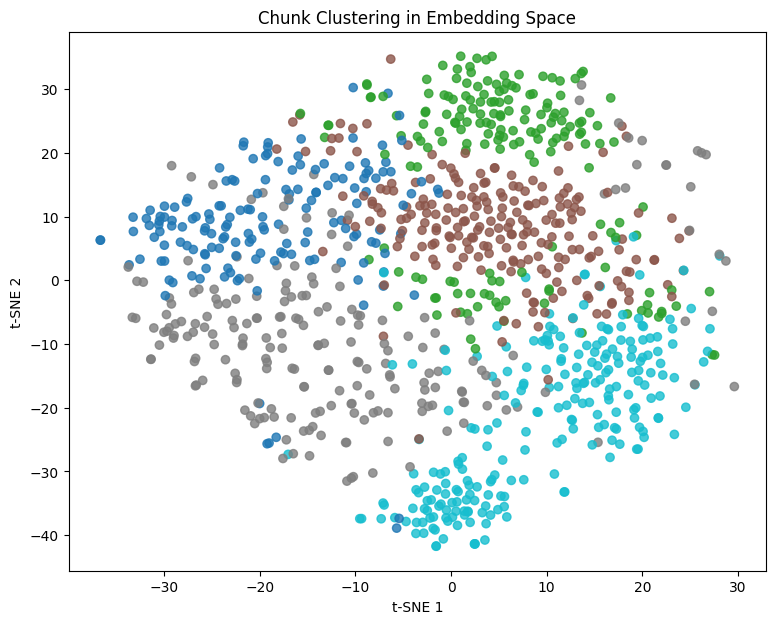

In [137]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(df_period["x_chunks"], df_period["y_chunks"], c=df_period["cluster_chunks"], cmap="tab10", alpha=0.8)
plt.title("Chunk Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")


In [53]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [ ]:
# persons_mentioned

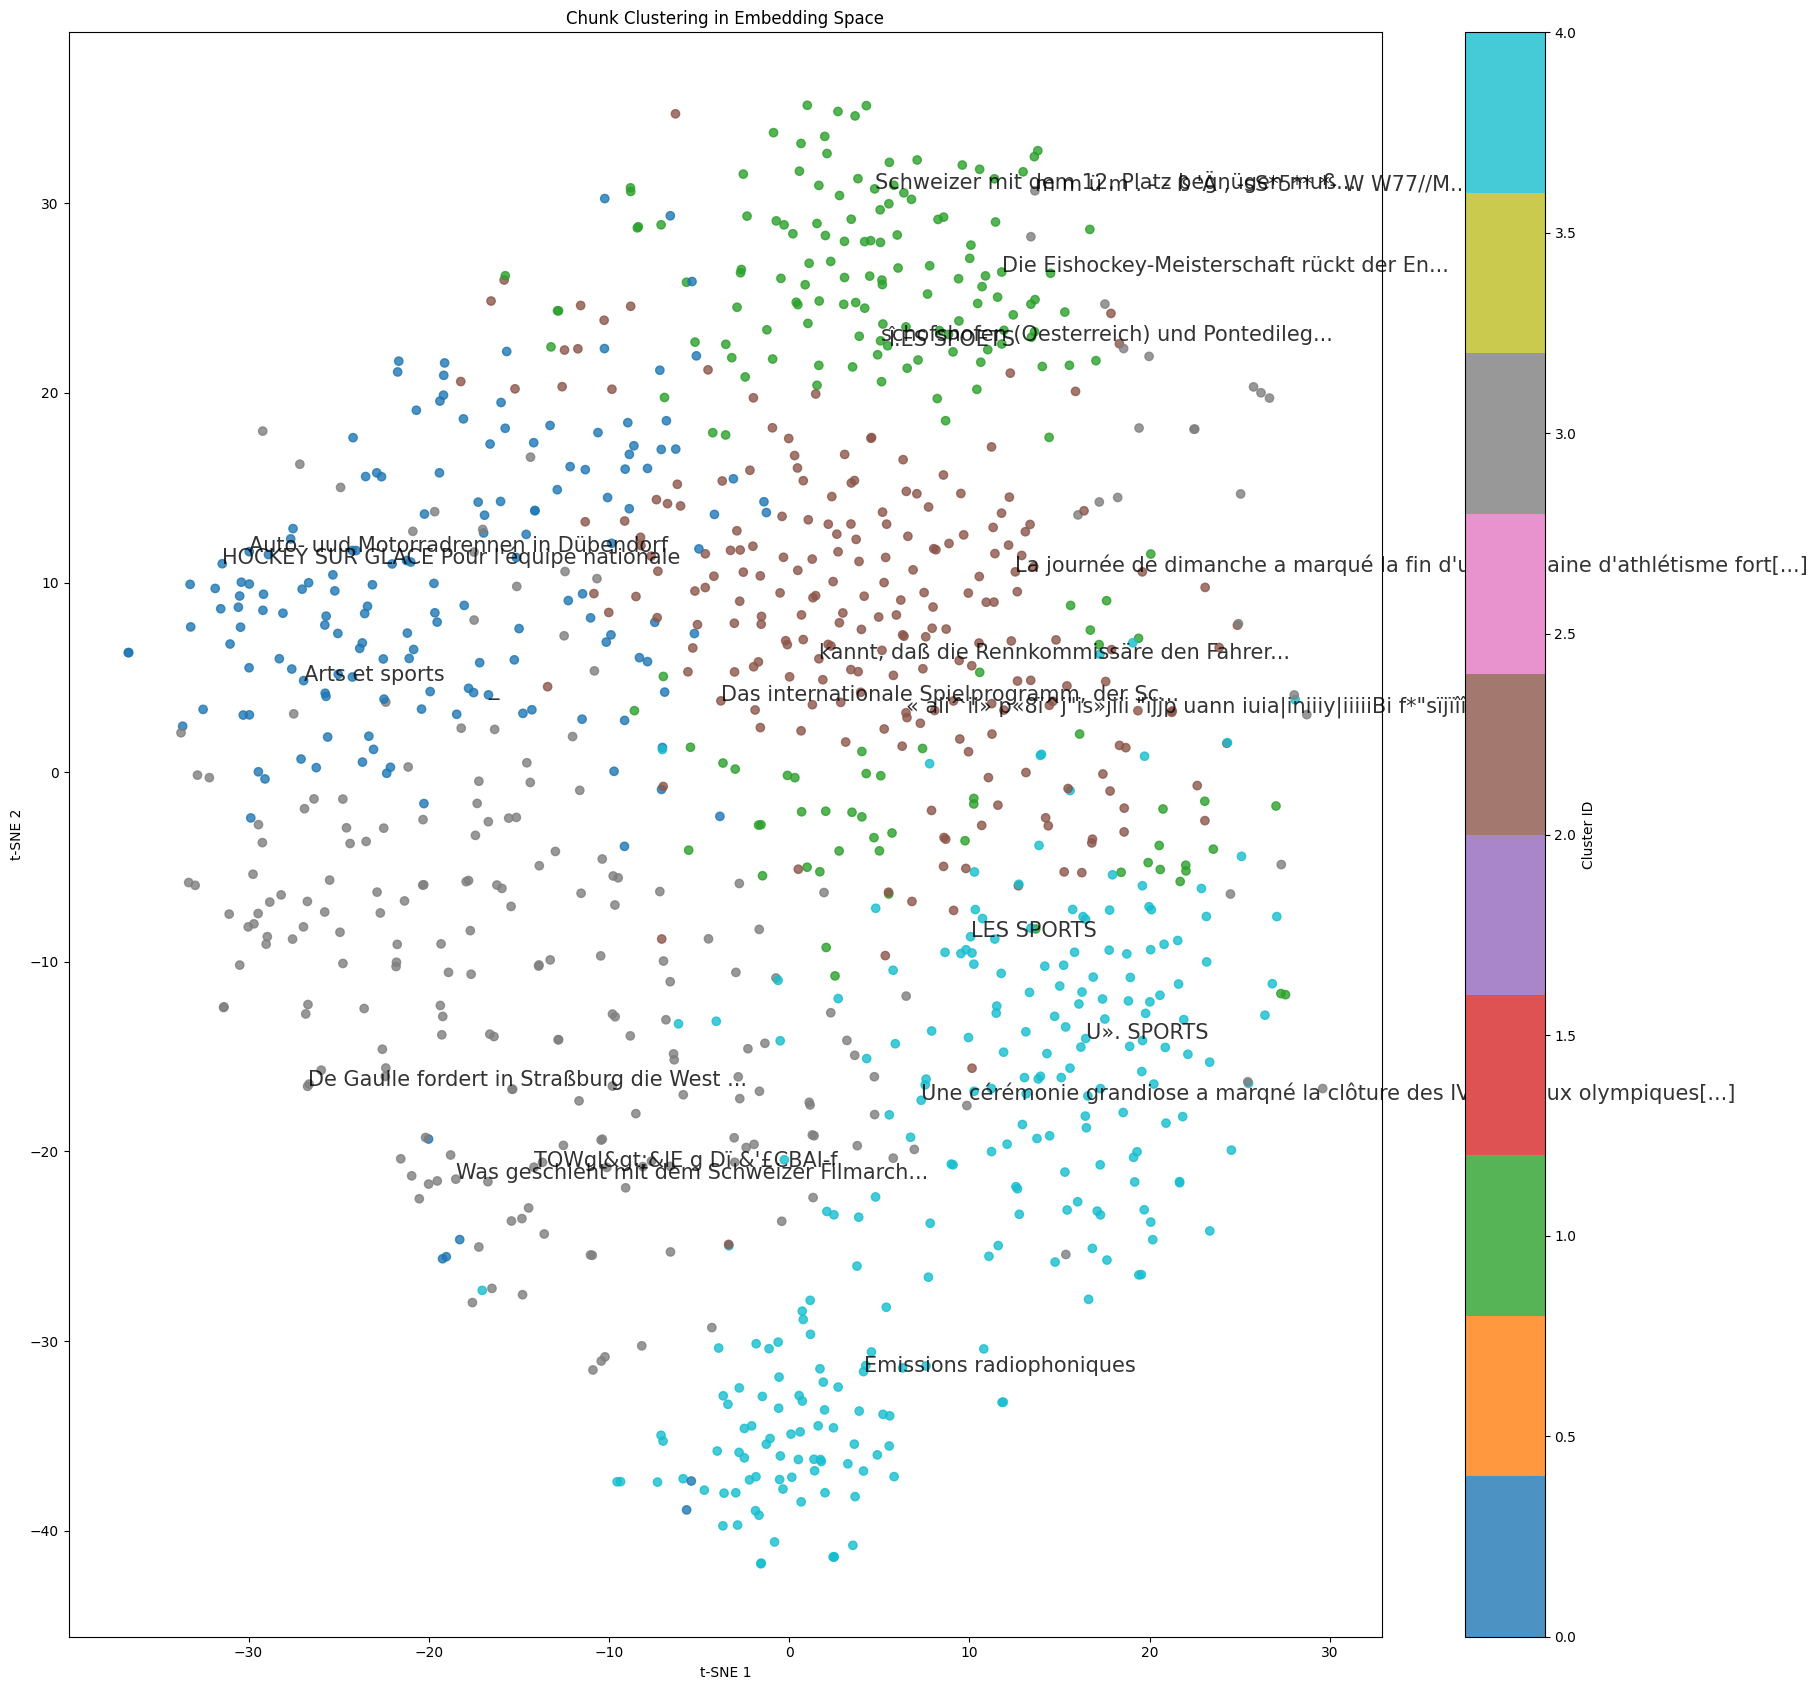

In [101]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(19, 17))
scatter = plt.scatter(df_period["x_chunks"], df_period["y_chunks"], c=df_period["cluster_chunks"], cmap="tab10", alpha=0.8)
plt.title("Chunk Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

for cluster_id in df_period["cluster_chunks"].unique():
    sample = df_period[df_period["cluster_chunks"] == cluster_id].sample(4, random_state=42)
    for _, row in sample.iterrows():
        plt.text(row["x_chunks"], row["y_chunks"], row["title"], fontsize=15, alpha=0.8)

plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

In [35]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [103]:
df_period.head(1)

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,transcriptLength,type,year,title_embedding,article_embedding,chunks,chunk_embedding,cluster_chunks,x_chunks,y_chunks
0,EXP-1934-02-05-a-i0060,NaN,NaN,CH,SNL,PING. PONG Championnat neuchâtelois et jurassi...,False,NaN,True,EXP-1934-02-05-a,...,1486,ar,1934,"[-0.0448267497, 0.0652769282, -0.1140181050000...","[-0.034329962000000006, 0.0653999299, -0.04998...","{'context': None, 'embedding': None, 'end_inde...","[-0.0148247033, -0.0021938346, -0.044421799500...",3,-2.382715,-19.789143


In [102]:
for _, item in df_period.iterrows():
    print(item.chunks)
        

{'context': None, 'embedding': None, 'end_index': 2539, 'id': 'chnk_3790073fa2c64672acde740b36132e20', 'start_index': 2507, 'text': 'Puis, sur une proposition de M. ', 'token_count': 9}
{'context': None, 'embedding': None, 'end_index': 4978, 'id': 'chnk_f021237318044296b9a3777f4eb313b6', 'start_index': 4823, 'text': '6. Eduard Reinalter ( St. Moritz) 5: 52. 7. Jean Dormond ( Villars) 5: 53, 8. Marcel von Allmon ( Scheidegg) 5: 55. 9. Daniel Girardet ( Zürich) 5: 57, 4. ', 'token_count': 57}
{'context': None, 'embedding': None, 'end_index': 10076, 'id': 'chnk_e4f563dce98f43f5975c25d1e00fb019', 'start_index': 10048, 'text': 'Lohmann 50 km in 43: 59, 6. ', 'token_count': 11}
{'context': None, 'embedding': None, 'end_index': 4401, 'id': 'chnk_e0967c92091d47d78b5d9fba7018d703', 'start_index': 4301, 'text': '22 h. 15, Variétés. 22 h. 45, Musique de danse. MUNSTER : 9 h. 30, Chant. 10 h ., Culte catholique. ', 'token_count': 38}
{'context': None, 'embedding': None, 'end_index': 636, 'id': 'ch

In [74]:
df_period.iloc[640].chunks

{'context': None,
 'embedding': None,
 'end_index': 4195,
 'id': 'chnk_6b40cd8a66b047098edbd5b742658a24',
 'start_index': 3709,
 'text': 'Als vor dem Kriege das Turnen in den Achsenmächten immer offenkundiger zu einer politisch-propagandistischen Attraktion wurde, brachen die Schweizer Turner jeglichen internationalen Verkehr ab. Um so verwunderlicher ist es in der Tat, daß, wo doch heute im Osten das Turnen nur unter politischem « Schutz » Existenzberechtigung hat, die schweizerische Turnerschaft nicht wie vor dem Kriege die Konsequenzen zieht, ja sogar die Nationalmannschaft zu einem Länderkampf nach Budapest dele-',
 'token_count': 140}

{'context': None, 'embedding': None, 'end_index': 14014, 'id': 'chnk_21e71d10cd6e46ecaf83e0e68ff05d67', 'start_index': 13231, 'text': "Ivan. Ruttkay, Hongrie ; 14. Maskay, Canada. Le tournoi de hockey sur glace Le tournoi de hockey sur glace s'est poursuivi devant un nombreux public ; le match le plus intéressant de la journée a été la rencontre Canada-Angleterre. Les Britanniques ont fourni une bonne partie et ont opposé une résistance sévère aux joueurs d'tique. Dans le second match, les deux teams des Etats-Unis et de l'Italie se sont trouvés en présence. Ce match a été remporté avec une facilité dérisoire par les joueurs américains. Les Italiens ont un système de jeu très primitif, où le jeu d'équipe n'a pour ainsi dire pas dc part. Le maniement du puck est très mauvais ; aussi n'est-il pas étonnant que l'équipe dc l'A. H. A. ait pu obtenir un pareil score. Canada bat Angleterre, 3-0 (1-0, 1-0, 1-0). ", 'token_count': 245}

In [ ]:
# # let's go chunky!!

# chunks = []

# # COLUMN VARIABLES
# TEXT = 'transcript'

# print("Chunking text columns...")
# for idx, row in tqdm(df_period.iterrows(), total=len(df_period)):
#         text = str(row[TEXT])
#         if text.strip():
#           chunks.append(chunker.chunk(text))

# df_period['chunks'] = chunks
# df_period_chunked = df_period.explode('chunks')
# df_period_chunked_sample = df_period_chunked.sample(1000, random_state=32)
# tqdm.pandas()
# df_period_chunked_sample['chunk_embedding'] = df_period_chunked_sample['chunks'].progress_apply(lambda x: convert_embedding(embed_text(x.text,'text')))



In [ ]:
# df_period_chunked_sample.reset_index(drop=True).to_json('olympic-general-chunks-sample-embedded.json')

In [ ]:
# import torch
# from transformers import pipeline

# pipeline = pipeline(
#     task="text2text-generation",
#     model="google-t5/t5-base",
#     dtype=torch.float16,
#     device=0
# )
# pipeline("translate English to French: The weather is nice today.")

In [127]:
if EMBEDDING_LEVEL == 'chunk':
  df_period = pd.read_json('olympic-general-chunks-sample-embedded.json')
else:
  df_period = pd.read_json('olympic-general-embedded.json')
df_period = df_period[~df_period[f'{EMBEDDING_LEVEL}_embedding'].isnull()]


In [128]:
df_period.head()

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,topics,totalPages,transcript,transcriptLength,type,year,title_embedding,article_embedding,chunks,chunk_embedding
0,EXP-1934-02-05-a-i0060,NaN,NaN,CH,SNL,PING. PONG Championnat neuchâtelois et jurassi...,False,NaN,True,EXP-1934-02-05-a,...,tm-fr-all-v2.0_tp25_fr|0.14 tm-fr-all-v2.0_tp5...,1,PING. PONG Championnat neuchâtelois et jurassi...,1486,ar,1934,"[-0.0448267497, 0.0652769282, -0.1140181050000...","[-0.034329962000000006, 0.0653999299, -0.04998...","{'context': None, 'embedding': None, 'end_inde...","[-0.0148247033, -0.0021938346, -0.044421799500..."
1,DTT-1942-01-15-a-i0036,NaN,NaN,CH,Migros,f Innere Kraft durch Winterferien Sportliche A...,False,NaN,True,DTT-1942-01-15-a,...,tm-de-all-v2.0_tp72_de|0.3 tm-de-all-v2.0_tp31...,1,f Innere Kraft durch Winterferien Sportliche A...,1386,ar,1942,"[-0.1104533002, -0.022621709900000002, -0.0651...","[-0.08136026560000001, 0.04792016, -0.02906009...","{'context': None, 'embedding': None, 'end_inde...","[-0.0198970716, 0.0979307517, -0.0025794248, -..."
2,DTT-1944-07-11-a-i0022,NaN,NaN,CH,Migros,"Wtr Mf * f », j a fr \ ______^___ flRn Entschl...",False,NaN,True,DTT-1944-07-11-a,...,tm-de-all-v2.0_tp72_de|0.479 tm-de-all-v2.0_tp...,1,"Wtr Mf * f », j a fr \ ______^___ flRn Entschl...",2809,ar,1944,"[-0.0176250301, 0.019606109700000002, -0.01716...","[-0.0143499104, 0.09960938250000001, -0.018219...","{'context': None, 'embedding': None, 'end_inde...","[-0.0134961661, 0.0940115601, -0.0134274578, 0..."
3,EXP-1935-08-17-a-i0071,NaN,NaN,CH,SNL,Emissions radiophoniques de samedi i-ixtrau au...,False,NaN,True,EXP-1935-08-17-a,...,tm-fr-all-v2.0_tp94_fr|0.656 tm-fr-all-v2.0_tp...,1,Emissions radiophoniques de samedi i-ixtrau au...,1265,ar,1935,"[-0.0301703177, 0.10173373670000001, 0.0352418...","[-0.0717601776, 0.0403700955, -0.0155300386, -...","{'context': None, 'embedding': None, 'end_inde...","[-0.0786307007, 0.1233951375, -0.0469811521, -..."
4,EXP-1932-08-10-a-i0075,NaN,NaN,CH,SNL,Les jeux olympiques à Los 4 ng _@ 8 ès NATATIO...,False,NaN,True,EXP-1932-08-10-a,...,tm-fr-all-v2.0_tp59_fr|0.427 tm-fr-all-v2.0_tp...,1,Les jeux olympiques à Los 4 ng _@ 8 ès NATATIO...,250,ar,1932,"[-0.0633300692, 0.0661942735, -0.0548848510000...","[-0.0614200644, 0.037880037000000005, -0.03041...","{'context': None, 'embedding': None, 'end_inde...","[-0.052805684500000005, 0.0739009529, -0.06637..."


In [130]:
df_period["locations_mentioned"] = df_period["locations_mentioned"].apply(
    lambda x: [loc.strip() for loc in x.split("|") if loc.strip()] if isinstance(x, str) else []
)

In [131]:
df_period.locations_mentioned

0      [Berne, Neuchâtel, Genève, baltent, Paris, Ess...
1      [Europa, Berlin, Lauberhorn—Wickibordhütte, Da...
2      [Zürich, 2. Litschi, Lohmann, Deutschlands, Aa...
3      [Neuchâtel, Neuchâtel, Suisse, MUNSTER, Zurich...
4      [Australie, France, Allemagne, Brésil, Hongrie...
                             ...                        
995    [Allemagne, Espagne, Europe, Autriche, Italie,...
996    [Suisse, Suisse, Suisse, Tchécoslovaquie, Tché...
997    [Kantons Zürich, Escher-Wyß-Platzes, Athen, Be...
998    [Sonntag Basel, Grasshoppers, Paris, wurde, To...
999    [Lausanne, Schweiz, Zürich, Westschweiz, Eidge...
Name: locations_mentioned, Length: 1000, dtype: object

In [129]:
df_period["persons_mentioned"] = df_period["persons_mentioned"].apply(
    lambda x: [p.strip() for p in x.split("|") if p.strip()] if isinstance(x, str) else []
)

In [108]:
from itertools import chain

location_counts = (
    pd.Series(chain.from_iterable(df_period["locations_mentioned"].dropna()))
    .value_counts()
)

person_counts = (
    pd.Series(chain.from_iterable(df_period["persons_mentioned"].dropna()))
    .value_counts()
)

In [110]:
location_counts.head(20)

Suisse        800
France        568
Etats-Unis    436
Italie        389
Angleterre    343
Lausanne      341
Suède         326
Paris         274
Hongrie       267
Schweiz       255
Zürich        249
Zurich        242
Neuchâtel     241
Finlande      238
Belgique      208
Danemark      197
Hollande      197
Berlin        188
Lugano        181
Bern          179
Name: count, dtype: int64

In [111]:
person_counts.head(20)

cpl                  52
Hôgger               44
Nemeth               42
Ahlden               42
Alex Jany            38
Beethoven            38
Ljungreen            35
Marcel Hansenne      34
Mel Patton           31
Zatopeck             28
Volkmer              28
Bieler               26
Steuri               25
Oblt                 25
HOCKEY               24
sgt                  24
Karl Frei            23
Mac Lane             23
Américain Cochran    21
Bolliger             21
Name: count, dtype: int64

In [123]:
from collections import Counter
from itertools import chain

for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id].dropna()
    # print(list(subset["locations_mentioned"]))
    # Compute entity frequencies
    locs = list(chain.from_iterable(subset["locations_mentioned"]))
    # pers = list(chain.from_iterable(
    #     subset["persons_mentioned"]
    # ))

In [152]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [162]:
cosine_similarity([[1, 2, 3]], [[1, 2, 3]])

array([[1.]])

In [141]:
df_period.head()

,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,transcriptLength,type,year,title_embedding,article_embedding,chunks,chunk_embedding,cluster_chunks,x_chunks,y_chunks
0,EXP-1934-02-05-a-i0060,NaN,NaN,CH,SNL,PING. PONG Championnat neuchâtelois et jurassi...,False,NaN,True,EXP-1934-02-05-a,...,1486,ar,1934,"[-0.0448267497, 0.0652769282, -0.1140181050000...","[-0.034329962000000006, 0.0653999299, -0.04998...","{'context': None, 'embedding': None, 'end_inde...","[-0.0148247033, -0.0021938346, -0.044421799500...",3,-2.382715,-19.789143
1,DTT-1942-01-15-a-i0036,NaN,NaN,CH,Migros,f Innere Kraft durch Winterferien Sportliche A...,False,NaN,True,DTT-1942-01-15-a,...,1386,ar,1942,"[-0.1104533002, -0.022621709900000002, -0.0651...","[-0.08136026560000001, 0.04792016, -0.02906009...","{'context': None, 'embedding': None, 'end_inde...","[-0.0198970716, 0.0979307517, -0.0025794248, -...",2,14.380722,-2.825704
2,DTT-1944-07-11-a-i0022,NaN,NaN,CH,Migros,"Wtr Mf * f », j a fr \ ______^___ flRn Entschl...",False,NaN,True,DTT-1944-07-11-a,...,2809,ar,1944,"[-0.0176250301, 0.019606109700000002, -0.01716...","[-0.0143499104, 0.09960938250000001, -0.018219...","{'context': None, 'embedding': None, 'end_inde...","[-0.0134961661, 0.0940115601, -0.0134274578, 0...",2,24.286926,1.524614
3,EXP-1935-08-17-a-i0071,NaN,NaN,CH,SNL,Emissions radiophoniques de samedi i-ixtrau au...,False,NaN,True,EXP-1935-08-17-a,...,1265,ar,1935,"[-0.0301703177, 0.10173373670000001, 0.0352418...","[-0.0717601776, 0.0403700955, -0.0155300386, -...","{'context': None, 'embedding': None, 'end_inde...","[-0.0786307007, 0.1233951375, -0.0469811521, -...",4,-2.078850,-34.469189
4,EXP-1932-08-10-a-i0075,NaN,NaN,CH,SNL,Les jeux olympiques à Los 4 ng _@ 8 ès NATATIO...,False,NaN,True,EXP-1932-08-10-a,...,250,ar,1932,"[-0.0633300692, 0.0661942735, -0.0548848510000...","[-0.0614200644, 0.037880037000000005, -0.03041...","{'context': None, 'embedding': None, 'end_inde...","[-0.052805684500000005, 0.0739009529, -0.06637...",1,2.029038,-2.057715


In [166]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster_chunks',
       'x_chunks', 'y_chunks'],
      dtype='object')

In [167]:
for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id]#.dropna()

    locs = list(chain.from_iterable(subset["locations_mentioned"]))
    pers = list(chain.from_iterable(
        subset["persons_mentioned"]
    ))
    # print(locs)
    # print(pers)

    loc_counts = Counter(locs)
    per_counts = Counter(pers)

    # Print cluster header
    print(f"\n🌀 Cluster {cluster_id} — {len(subset)} articles")
    print("=" * 70)

    # Print sample transcripts
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        transcript_preview = row["transcript"].strip().replace("\n", " ")
        title = row["title"]
        year = row["year"]
        print(f"   • {year} --- {title} - {transcript_preview[:120]}... ({row['transcriptLength']} chars)")

    # Print entity frequencies
    print("\n📍 Top locations:")
    for loc, count in loc_counts.most_common(5):
        print(f"   - {loc}: {count}")

    print("\n👤 Top persons:")
    for per, count in per_counts.most_common(5):
        print(f"   - {per}: {count}")

    print("-" * 70)


🌀 Cluster 0 — 158 articles
   • 1947 --- Arts et sports - Arts et sports Le nombre croissant des compétitions sportives, le nombreux public qu'elles attirent et l'enthousiasme qu... (742 chars)
   • 1948 --- _ - _ In Kanton demonstrierten 20 000 chinesische Rußland entsendet als Beobachter eine Delegation zu den Olympischen Spiele... (335 chars)
   • 1939 --- HOCKEY SUR GLACE Pour l'équipe nationale - HOCKEY SUR GLACE Pour l'équipe nationale La ligue suisse a sélectionné vingt joueurs pour les matches militaires qui ser... (158 chars)
   • 1950 --- Auto- uud Motorradrennen in Dübendorf - Auto- uud Motorradrennen in Dübendorf ^ mrW ^^ wfJ 7 /^ KJm Die Motorradrennen seh. Prächtiges Frühsommerwetter belohnte... (3007 chars)
   • 1936 --- Les sports de dimanche - Les sports de dimanche FOOTBALL L'ouverture du championnat suisse n'est plus éloigné. Aussi les clubs procèdent-ils à l'... (411 chars)

📍 Top locations:
   - Suisse: 93
   - Paris: 53
   - Lausanne: 42
   - Neuchâtel: 39
   - S

In [184]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Words to test
words = ["winterspiele", "olympics", "sommerspiele", "Moritz", "London", "Londres"]
# words = ["""The modern Olympic Games (Olympics; French: Jeux olympiques)[a][1] are the world's preeminent international sporting events. They feature summer and winter sports competitions in which thousands of athletes from around the world participate in a variety of competitions. The Olympic Games, open to both amateur and professional athletes, involves more than 200 teams, each team representing a sovereign state or territory. By default, the Games generally substitute for any world championships during the year in which they take place (however, each class usually maintains its own records).[2] The Olympics are staged every four years. Since 1994, they have alternated between the Summer and Winter Olympics every two years during the four-year Olympiad.[3][4] """]

# words = ["""The 1948 Summer Olympics, officially the Games of the XIV Olympiad and officially branded as London 1948, were an international multi-sport event held from 29 July to 14 August 1948 in London, United Kingdom. Following a twelve-year hiatus caused by the outbreak of World War II, these were the first Summer Olympics held since the 1936 Games in Berlin. The 1940 Olympic Games had been scheduled for Tokyo and then for Helsinki, while the 1944 Olympic Games had been provisionally planned for London. This was the second time London hosted the Olympic Games, having previously hosted them in 1908, making it the second city to host the Summer Olympics twice (after Paris). The Olympics would return again to London 64 years later in 2012, making London the first city to host the games thrice, and the only such city until Paris, who hosted their third games in 2024, and Los Angeles, who will host theirs in 2028. The 1948 Olympic Games were also the first of two summer Games held under the IOC presidency of Sigfrid Edström. """]

# words = ["""The 1948 Winter Olympics, officially known as the V Olympic Winter Games (German: V. Olympische Winterspiele; French: Ves Jeux olympiques d'hiver; Italian: V Giochi olimpici invernali; Romansh: V Gieus olimpics d'enviern) and commonly known as St. Moritz 1948 (French: Saint-Moritz 1948; Romansh: San Murezzan 1948), were a winter multi-sport event held from 30 January to 8 February 1948 in St. Moritz, Switzerland. The Games were the first to be celebrated after World War II; it had been twelve years since the last Winter Games in 1936. """]

# words = ["""Titanic was a British ocean liner that sank in the early hours of 15 April 1912 as a result of striking an iceberg on her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, approximately 1,500 died (estimates vary), making the incident one of the deadliest peacetime sinkings of a single ship.[4] Titanic, operated by White Star Line, carried some of the wealthiest people in the world, as well as hundreds of emigrants from the British Isles, Scandinavia, and elsewhere in Europe who were seeking a new life in the United States and Canada. The disaster drew public attention, spurred major changes in maritime safety regulations, and inspired a lasting legacy in popular culture. It was the second time White Star Line had lost a ship on her maiden voyage, the first being RMS Tayleur in 1854.[5]"""]

for word in words:
    print(f"\n🏅 Word: '{word}'")
    print("=" * 70)
    
    # Embed the word once
    word_emb_b64 = embed_text(word, target="text")
    word_emb = np.array(convert_embedding(word_emb_b64)).reshape(1, -1)
    
    results = []
    
    for cluster_id in sorted(df_period["cluster_chunks"].dropna().unique()):
        subset = df_period[df_period["cluster_chunks"] == cluster_id].copy()
        valid_rows = []
        
        for _, row in subset.iterrows():
            try:
                emb = np.array(row["chunk_embedding"], dtype=float).reshape(1, -1)
                sim = cosine_similarity(emb, word_emb)[0][0]

                sim_check = cosine_similarity(word_emb, word_emb)[0][0]
                # print('!!!!!!', sim_check)
                valid_rows.append(sim)
            except Exception:
                continue
        
        mean_sim = np.mean(valid_rows) if valid_rows else np.nan
        results.append((cluster_id, mean_sim, len(valid_rows)))

    
    # Convert results to DataFrame and sort
    df_sim = pd.DataFrame(results, columns=["cluster_id", "mean_similarity", "num_samples"])
    df_sim = df_sim.sort_values("mean_similarity", ascending=False)
    
    # Print top 3 clusters with excerpts
    for _, row in df_sim.head(5).iterrows():
        cid = int(row['cluster_id'])
        print(f"\n📦 Cluster {cid:>3}: "
              f"Mean similarity = {row['mean_similarity']:.4f} "
              f"({int(row['num_samples'])} samples)")
        print("-" * 70)
        
        # Pick top 3 similar rows from this cluster
        subset = df_period[df_period["cluster_chunks"] == cid].copy()
        subset["similarity"] = subset["chunk_embedding"].apply(
            lambda emb: cosine_similarity(np.array(emb, dtype=float).reshape(1, -1), word_emb)[0][0]
        )
        subset = subset.sort_values("similarity", ascending=False).head(3)
        
        # Print transcript excerpts
        for i, r in subset.iterrows():
            excerpt = r["transcript"].strip().replace("\n", " ")[:1000]
            uid = r["uid"]
            print(f"   • {uid} -- {excerpt}... (sim={r['similarity']:.4f}, len={r['transcriptLength']})")
        print("-" * 70)


🏅 Word: 'winterspiele'

📦 Cluster   0: Mean similarity = 0.4942 (158 samples)
----------------------------------------------------------------------
   • DTT-1948-02-16-a-i0077 -- Die Olympischen Sommerspiele in London Unterkunft und Verpflegung Von unserem Londoner Sport-Korrespondenten G-. B. Es ist noch verhältnismäßig still um die Vorbereitung der Olympischen Sommerspiele in London. Das bedeutet, aber keineswegs, daß nicht gearbeitet wird; es wird sogar sehr fest, gearbeitet, und es ist jetzt, schon sicher, daß die Organisation der Spiele mustergültig sein wird. Großbritannien betrachtet es als eine Ehre, den Sportlern aus allen Herren Ländern so viele Wünsche wie möglich zu erfüllen und ihnen den Anlaß zu einem unvergeßlichen Erlebnis zu machen. Man kann sich leicht vorstellen, daß vor allem die Unterbringung der Athleten große Schwierigkeiten mit sich bringt. Ihr Berichterstatter entschloß sich deshalb, den Mann, der für die Placierung der Wettkämpfer und Offiziellen besorgt ist

In [142]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 4))
# plt.bar(df_sim["cluster_id"], df_sim["mean_similarity"])
# plt.title("Mean Similarity to 'Olympics' Embedding per Cluster")
# plt.xlabel("Cluster ID")
# plt.ylabel("Cosine Similarity")
# plt.show()

NameError: name 'olympics_emb_b64' is not defined

# Fin